# Roller Coaster Classification Part 2

In [2]:
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.pipeline import Pipeline
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

df = pd.read_csv('roller_coasters.csv')

df = df[df["material_type"].str.lower() != "na"]
df = df.dropna(subset=["material_type"])

# Features and target
X = df.drop(columns=["material_type"])
y = df["material_type"]

from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)

from sklearn.preprocessing import LabelEncoder

le = LabelEncoder()
y_train_enc = le.fit_transform(y_train)
y_test_enc = le.transform(y_test)

from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import StandardScaler, OneHotEncoder

# numeric and categorical feature lists
numeric_features = ["speed", "height", "length", "num_inversions"]
categorical_features = [col for col in X.columns if col not in numeric_features]

# build transformer
preprocessor = ColumnTransformer(
    transformers=[
        ("num", StandardScaler(), numeric_features),
        ("cat", OneHotEncoder(handle_unknown="ignore"), categorical_features)
    ]
)

# fit on training, transform both train/test
X_train_prep = preprocessor.fit_transform(X_train)
X_test_prep = preprocessor.transform(X_test)

# make sure Keras sees float32
X_train_prep = X_train_prep.astype("float32")
X_test_prep = X_test_prep.astype("float32")

In [3]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers

model = keras.Sequential([
    keras.Input(shape=(X_train_prep.shape[1],)),
    layers.Dense(128, activation="relu"),
    layers.Dropout(0.3),
    layers.Dense(64, activation="relu"),
    layers.Dropout(0.3),
    layers.Dense(3, activation="softmax")  # 3 classes
])

model.compile(
    optimizer="adam",
    loss="sparse_categorical_crossentropy",
    metrics=["accuracy"]
)

# convert sparse matrices to dense numpy arrays
X_train_prep = X_train_prep.toarray()
X_test_prep = X_test_prep.toarray()

history = model.fit(
    X_train_prep, y_train_enc,
    validation_split=0.2,
    epochs=30,
    batch_size=32,
    verbose=1
)

2025-08-19 16:32:33.116805: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.


Epoch 1/30
46/46 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - accuracy: 0.0176 - loss: nan - val_accuracy: 0.0083 - val_loss: nan
Epoch 2/30
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.0069 - loss: nan - val_accuracy: 0.0083 - val_loss: nan
Epoch 3/30
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.0095 - loss: nan - val_accuracy: 0.0083 - val_loss: nan
Epoch 4/30
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.0129 - loss: nan - val_accuracy: 0.0083 - val_loss: nan
Epoch 5/30
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.0079 - loss: nan - val_accuracy: 0.0083 - val_loss: nan
Epoch 6/30
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.0079 - loss: nan - val_accuracy: 0.0083 - val_loss: nan
Epoch 7/30
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.0113 - loss: nan - val_accuracy: 0.0083 - val_loss: nan
Epoch 8/30
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.0097 - loss: nan - val_accuracy: 0.0083 - val_loss: nan
Epoch 9/30
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s

15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step
Test Accuracy: 0.0088

Classification Report:
              precision    recall  f1-score   support

      Hybrid       0.01      1.00      0.02         4
       Steel       0.00      0.00      0.00       412
      Wooden       0.00      0.00      0.00        38

    accuracy                           0.01       454
   macro avg       0.00      0.33      0.01       454
weighted avg       0.00      0.01      0.00       454



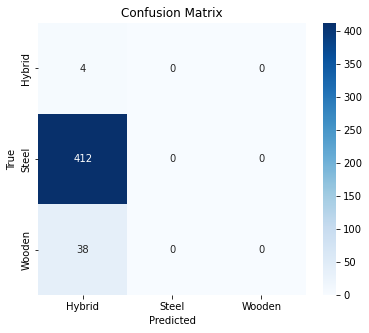

In [4]:
from sklearn.metrics import classification_report, confusion_matrix
import seaborn as sns

# Predictions
y_pred_probs = model.predict(X_test_prep)
y_pred = np.argmax(y_pred_probs, axis=1)   # take highest prob as class

# If y_test_enc is one-hot, convert back to integer labels
if y_test_enc.ndim > 1 and y_test_enc.shape[1] > 1:
    y_true = np.argmax(y_test_enc, axis=1)
else:
    y_true = y_test_enc  

# Accuracy
test_loss, test_acc = model.evaluate(X_test_prep, y_test_enc, verbose=0)
print(f"Test Accuracy: {test_acc:.4f}")

# Classification report with zero_division=0 to suppress warnings
print("\nClassification Report:")
print(classification_report(y_true, y_pred, target_names=le.classes_, zero_division=0))

# Confusion matrix
cm = confusion_matrix(y_true, y_pred)

plt.figure(figsize=(6,5))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", 
            xticklabels=le.classes_, yticklabels=le.classes_)
plt.xlabel("Predicted")
plt.ylabel("True")
plt.title("Confusion Matrix")
plt.show()

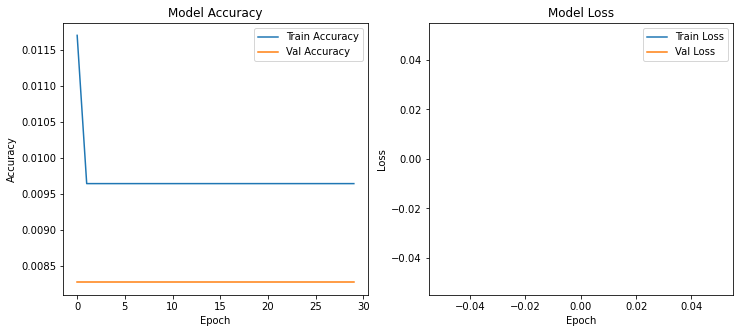

In [5]:
# Plot training curves
plt.figure(figsize=(12,5))

# Accuracy
plt.subplot(1,2,1)
plt.plot(history.history['accuracy'], label='Train Accuracy')
plt.plot(history.history['val_accuracy'], label='Val Accuracy')
plt.title("Model Accuracy")
plt.xlabel("Epoch")
plt.ylabel("Accuracy")
plt.legend()

# Loss
plt.subplot(1,2,2)
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Val Loss')
plt.title("Model Loss")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.legend()

plt.show()

## About This Model

It's **complete garbage** but it might just have to do with class imbalance, look at how many steel roller coasters there are compared to wood

## New Approach: Removing Hybrids

Why? Because traditionally roller coasters made purely with wood and purely with steel were more common. Hybrids are a modern thing

In [1]:
import pandas as pd
df = pd.read_csv('roller_coasters.csv')
df = df[df['material_type'] != 'Hybrid']
df.head()

,name,material_type,seating_type,speed,height,length,num_inversions,manufacturer,park,status
0,Goudurix,Steel,Sit Down,75.0,37.0,950.0,7.0,Vekoma,Parc Asterix,status.operating
1,Dream catcher,Steel,Suspended,45.0,25.0,600.0,0.0,Vekoma,Bobbejaanland,status.operating
2,Alucinakis,Steel,Sit Down,30.0,8.0,250.0,0.0,Zamperla,Terra Mítica,status.operating
3,Anaconda,Wooden,Sit Down,85.0,35.0,1200.0,0.0,William J. Cobb,Walygator Parc,status.operating
4,Azteka,Steel,Sit Down,55.0,17.0,500.0,0.0,Soquet,Le Pal,status.operating


In [2]:
df.describe()

,speed,height,length,num_inversions
count,1459.000000,1647.000000,1656.000000,2385.000000
mean,69.789582,26.566485,600.372585,0.803774
std,28.331523,35.160355,391.111201,1.650982
min,0.000000,0.000000,-1.000000,0.000000
25%,47.000000,13.000000,330.000000,0.000000
50%,72.000000,22.000000,489.500000,0.000000
75%,87.000000,34.000000,825.500000,1.000000
max,240.000000,902.000000,2920.000000,14.000000


In [3]:
df.shape

(2781, 10)

In [4]:
df.isna().sum()

name                 3
material_type        0
seating_type         0
speed             1322
height            1134
length            1125
num_inversions     396
manufacturer         0
park                 0
status               0
dtype: int64

In [5]:
df = df[df['name'].notna()]
df = df[df["material_type"].str.lower() != "na"]
df = df.dropna(subset=["material_type"])
num = ["speed", "height", "length", "num_inversions"]
for i in num:
    mean_value=df[i].mean()
    df[i].fillna(value=mean_value, inplace=True)
df.isna().sum()

name              0
material_type     0
seating_type      0
speed             0
height            0
length            0
num_inversions    0
manufacturer      0
park              0
status            0
dtype: int64

In [6]:
# Features and target
X = df.drop(columns=["material_type"])
y = df["material_type"]

from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)

from sklearn.preprocessing import LabelEncoder

le = LabelEncoder()
y_train_enc = le.fit_transform(y_train)
y_test_enc = le.transform(y_test)

from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import StandardScaler, OneHotEncoder

# numeric and categorical feature lists
numeric_features = ["speed", "height", "length", "num_inversions"]
categorical_features = [col for col in X.columns if col not in numeric_features]

# build transformer
preprocessor = ColumnTransformer(
    transformers=[
        ("num", StandardScaler(), numeric_features),
        ("cat", OneHotEncoder(handle_unknown="ignore"), categorical_features)
    ]
)

# fit on training, transform both train/test
X_train_prep = preprocessor.fit_transform(X_train)
X_test_prep = preprocessor.transform(X_test)

# make sure Keras sees float32
X_train_prep = X_train_prep.astype("float32")
X_test_prep = X_test_prep.astype("float32")

In [9]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
import numpy as np

model = keras.Sequential([
    keras.Input(shape=(X_train_prep.shape[1],)),
    layers.Dense(128, activation="relu"),
    layers.Dropout(0.3),
    layers.Dense(64, activation="relu"),
    layers.Dropout(0.3),
    layers.Dense(2, activation="softmax")  # 2 classes
])

model.compile(
    optimizer="adam",
    loss="sparse_categorical_crossentropy",
    metrics=["accuracy"]
)

# convert sparse matrices to dense numpy arrays
from scipy.sparse import issparse
if issparse(X_train_prep):
    X_train_prep = X_train_prep.toarray()
if issparse(X_test_prep):
    X_test_prep = X_test_prep.toarray()

history = model.fit(
    X_train_prep, y_train_enc,
    validation_split=0.2,
    epochs=30,
    batch_size=32,
    verbose=1
)

Epoch 1/30
45/45 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - accuracy: 0.8366 - loss: 0.4883 - val_accuracy: 0.8972 - val_loss: 0.2423
Epoch 2/30
45/45 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.9197 - loss: 0.1852 - val_accuracy: 0.8972 - val_loss: 0.1862
Epoch 3/30
45/45 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.9371 - loss: 0.1122 - val_accuracy: 0.9278 - val_loss: 0.1547
Epoch 4/30
45/45 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.9733 - loss: 0.0834 - val_accuracy: 0.9444 - val_loss: 0.1266
Epoch 5/30
45/45 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.9879 - loss: 0.0500 - val_accuracy: 0.9528 - val_loss: 0.1193
Epoch 6/30
45/45 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.9925 - loss: 0.0308 - val_accuracy: 0.9528 - val_loss: 0.1259
Epoch 7/30
45/45 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.9986 - loss: 0.0125 - val_accuracy: 0.9528 - val_loss: 0.1237
Epoch 8/30
45/45 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.9999 - loss: 0.0074 - val_accuracy: 0.9528 - val_loss:

15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
Test Accuracy: 0.9444

Classification Report:
              precision    recall  f1-score   support

       Steel       0.96      0.99      0.97       412
      Wooden       0.76      0.50      0.60        38

    accuracy                           0.94       450
   macro avg       0.86      0.74      0.79       450
weighted avg       0.94      0.94      0.94       450



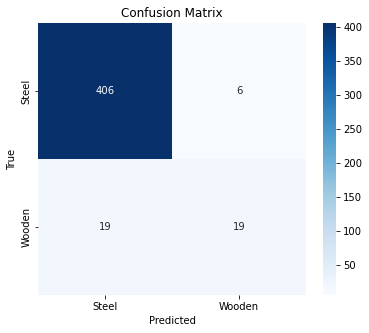

In [11]:
from sklearn.metrics import classification_report, confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

# Predictions
y_pred_probs = model.predict(X_test_prep)
y_pred = np.argmax(y_pred_probs, axis=1)   # take highest prob as class

# If y_test_enc is one-hot, convert back to integer labels
if y_test_enc.ndim > 1 and y_test_enc.shape[1] > 1:
    y_true = np.argmax(y_test_enc, axis=1)
else:
    y_true = y_test_enc  

# Accuracy
test_loss, test_acc = model.evaluate(X_test_prep, y_test_enc, verbose=0)
print(f"Test Accuracy: {test_acc:.4f}")

# Classification report with zero_division=0 to suppress warnings
print("\nClassification Report:")
print(classification_report(y_true, y_pred, target_names=le.classes_, zero_division=0))

# Confusion matrix
cm = confusion_matrix(y_true, y_pred)

plt.figure(figsize=(6,5))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", 
            xticklabels=le.classes_, yticklabels=le.classes_)
plt.xlabel("Predicted")
plt.ylabel("True")
plt.title("Confusion Matrix")
plt.show()

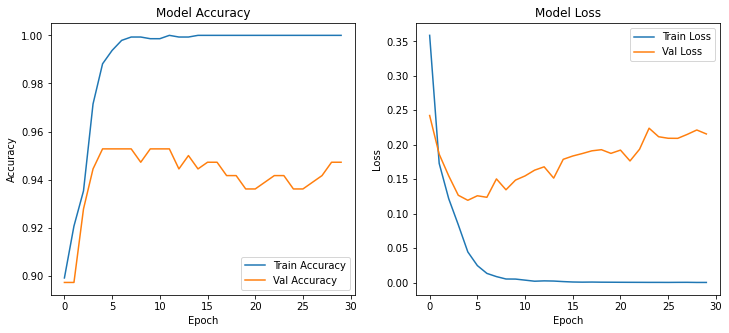

In [12]:
# Plot training curves
plt.figure(figsize=(12,5))

# Accuracy
plt.subplot(1,2,1)
plt.plot(history.history['accuracy'], label='Train Accuracy')
plt.plot(history.history['val_accuracy'], label='Val Accuracy')
plt.title("Model Accuracy")
plt.xlabel("Epoch")
plt.ylabel("Accuracy")
plt.legend()

# Loss
plt.subplot(1,2,2)
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Val Loss')
plt.title("Model Loss")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.legend()

plt.show()

Much better but might be because most of the remaining data is steel

## Removing Steel

In [13]:
df = pd.read_csv('roller_coasters.csv')
df = df[df['material_type'] != 'Steel']
df.head()

,name,material_type,seating_type,speed,height,length,num_inversions,manufacturer,park,status
3,Anaconda,Wooden,Sit Down,85.0,35.0,1200.0,0.0,William J. Cobb,Walygator Parc,status.operating
25,Loup Garou,Wooden,Sit Down,80.0,28.0,1035.0,0.0,Vekoma,Walibi Belgium,status.operating
26,Magnus Colossus,Wooden,Sit Down,92.0,38.0,1150.0,0.0,RCCA,Terra Mítica,status.closed.temporarily
40,Tonnerre de Zeus,Wooden,Sit Down,84.0,30.0,1233.0,0.0,CCI,Parc Asterix,status.operating
47,Bandit,Wooden,Sit Down,80.0,28.0,1099.0,0.0,RCCA,Movie Park Germany,status.operating


In [14]:
df.describe()

,speed,height,length,num_inversions
count,304.000000,358.000000,394.000000,379.000000
mean,74.812500,26.527933,720.170051,0.751979
std,25.793692,16.284345,404.796935,1.562360
min,0.000000,0.000000,0.000000,0.000000
25%,60.000000,15.000000,395.000000,0.000000
50%,80.000000,26.000000,721.500000,0.000000
75%,90.000000,33.750000,993.750000,0.000000
max,137.000000,200.000000,2243.000000,10.000000


In [15]:
df.isna().sum()

name                2
material_type       0
seating_type        0
speed             439
height            385
length            349
num_inversions    364
manufacturer        0
park                0
status              0
dtype: int64

In [16]:
df = df[df['name'].notna()]
df = df[df["material_type"].str.lower() != "na"]
df = df.dropna(subset=["material_type"])
num = ["speed", "height", "length", "num_inversions"]
for i in num:
    mean_value=df[i].mean()
    df[i].fillna(value=mean_value, inplace=True)
df.isna().sum()

name              0
material_type     0
seating_type      0
speed             0
height            0
length            0
num_inversions    0
manufacturer      0
park              0
status            0
dtype: int64

In [17]:
# Features and target
X = df.drop(columns=["material_type"])
y = df["material_type"]

from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)

from sklearn.preprocessing import LabelEncoder

le = LabelEncoder()
y_train_enc = le.fit_transform(y_train)
y_test_enc = le.transform(y_test)

from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import StandardScaler, OneHotEncoder

# numeric and categorical feature lists
numeric_features = ["speed", "height", "length", "num_inversions"]
categorical_features = [col for col in X.columns if col not in numeric_features]

# build transformer
preprocessor = ColumnTransformer(
    transformers=[
        ("num", StandardScaler(), numeric_features),
        ("cat", OneHotEncoder(handle_unknown="ignore"), categorical_features)
    ]
)

# fit on training, transform both train/test
X_train_prep = preprocessor.fit_transform(X_train)
X_test_prep = preprocessor.transform(X_test)

# make sure Keras sees float32
X_train_prep = X_train_prep.astype("float32")
X_test_prep = X_test_prep.astype("float32")

In [18]:
model = keras.Sequential([
    keras.Input(shape=(X_train_prep.shape[1],)),
    layers.Dense(128, activation="relu"),
    layers.Dropout(0.3),
    layers.Dense(64, activation="relu"),
    layers.Dropout(0.3),
    layers.Dense(2, activation="softmax")  # 2 classes
])

model.compile(
    optimizer="adam",
    loss="sparse_categorical_crossentropy",
    metrics=["accuracy"]
)

# convert sparse matrices to dense numpy arrays
from scipy.sparse import issparse
if issparse(X_train_prep):
    X_train_prep = X_train_prep.toarray()
if issparse(X_test_prep):
    X_test_prep = X_test_prep.toarray()

history = model.fit(
    X_train_prep, y_train_enc,
    validation_split=0.2,
    epochs=30,
    batch_size=32,
    verbose=1
)

Epoch 1/30
5/5 ━━━━━━━━━━━━━━━━━━━━ 2s 45ms/step - accuracy: 0.7366 - loss: 0.6298 - val_accuracy: 0.9118 - val_loss: 0.4918
Epoch 2/30
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - accuracy: 0.9053 - loss: 0.4828 - val_accuracy: 0.9118 - val_loss: 0.3660
Epoch 3/30
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - accuracy: 0.9153 - loss: 0.4206 - val_accuracy: 0.9118 - val_loss: 0.2765
Epoch 4/30
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - accuracy: 0.9027 - loss: 0.3140 - val_accuracy: 0.9118 - val_loss: 0.2226
Epoch 5/30
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - accuracy: 0.8918 - loss: 0.3075 - val_accuracy: 0.9118 - val_loss: 0.1923
Epoch 6/30
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - accuracy: 0.8766 - loss: 0.2703 - val_accuracy: 0.9118 - val_loss: 0.1760
Epoch 7/30
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - accuracy: 0.8905 - loss: 0.2432 - val_accuracy: 0.9118 - val_loss: 0.1664
Epoch 8/30
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - accuracy: 0.8957 - loss: 0.2409 - val_accuracy: 0.9118 - val_loss: 0.1625
Ep

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step
Test Accuracy: 0.9286

Classification Report:
              precision    recall  f1-score   support

      Hybrid       0.60      0.75      0.67         4
      Wooden       0.97      0.95      0.96        38

    accuracy                           0.93        42
   macro avg       0.79      0.85      0.81        42
weighted avg       0.94      0.93      0.93        42



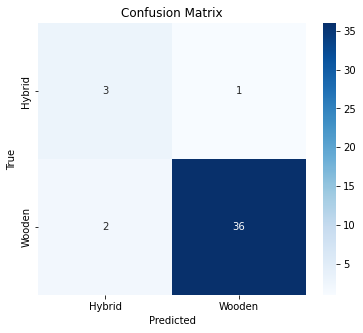

In [19]:
# Predictions
y_pred_probs = model.predict(X_test_prep)
y_pred = np.argmax(y_pred_probs, axis=1)   # take highest prob as class

# If y_test_enc is one-hot, convert back to integer labels
if y_test_enc.ndim > 1 and y_test_enc.shape[1] > 1:
    y_true = np.argmax(y_test_enc, axis=1)
else:
    y_true = y_test_enc  

# Accuracy
test_loss, test_acc = model.evaluate(X_test_prep, y_test_enc, verbose=0)
print(f"Test Accuracy: {test_acc:.4f}")

# Classification report with zero_division=0 to suppress warnings
print("\nClassification Report:")
print(classification_report(y_true, y_pred, target_names=le.classes_, zero_division=0))

# Confusion matrix
cm = confusion_matrix(y_true, y_pred)

plt.figure(figsize=(6,5))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", 
            xticklabels=le.classes_, yticklabels=le.classes_)
plt.xlabel("Predicted")
plt.ylabel("True")
plt.title("Confusion Matrix")
plt.show()

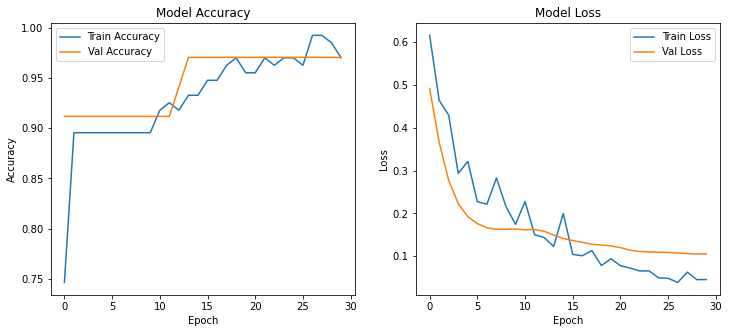

In [20]:
# Plot training curves
plt.figure(figsize=(12,5))

# Accuracy
plt.subplot(1,2,1)
plt.plot(history.history['accuracy'], label='Train Accuracy')
plt.plot(history.history['val_accuracy'], label='Val Accuracy')
plt.title("Model Accuracy")
plt.xlabel("Epoch")
plt.ylabel("Accuracy")
plt.legend()

# Loss
plt.subplot(1,2,2)
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Val Loss')
plt.title("Model Loss")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.legend()

plt.show()